In [336]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
  
abalone = fetch_ucirepo(id=1)
X = abalone.data.features
y = abalone.data.targets

df = pd.concat([X, y], axis=1)
print("numbers:", len(df))
df.head(100)


numbers: 4177


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
...,...,...,...,...,...,...,...,...,...
95,M,0.665,0.535,0.195,1.6060,0.5755,0.3880,0.480,14
96,M,0.535,0.435,0.150,0.7250,0.2690,0.1385,0.250,9
97,M,0.470,0.375,0.130,0.5230,0.2140,0.1320,0.145,8
98,M,0.470,0.370,0.130,0.5225,0.2010,0.1330,0.165,7


In [337]:
df['Rings'] = pd.to_numeric(df['Rings'])
# One-hot encode the 'Sex' column
df = pd.get_dummies(df, columns=['Sex'], prefix='Sex')

for column in df.select_dtypes('number').columns:
    if df[column].mean() < 1.0:
        df[column] = df[column] * 200

df.describe()



,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,104.798420,81.576251,27.903280,165.748432,71.873498,36.118722,47.766172,9.933684
std,24.018583,19.847973,8.365411,98.077804,44.392590,21.922850,27.840534,3.224169
min,15.000000,11.000000,0.000000,0.400000,0.200000,0.100000,0.300000,1.000000
25%,90.000000,70.000000,23.000000,88.300000,37.200000,18.700000,26.000000,8.000000
50%,109.000000,85.000000,28.000000,159.900000,67.200000,34.200000,46.800000,9.000000
75%,123.000000,96.000000,33.000000,230.600000,100.400000,50.600000,65.800000,11.000000
max,163.000000,130.000000,226.000000,565.100000,297.600000,152.000000,201.000000,29.000000


Length               Axes(0.125,0.653529;0.227941x0.226471)
Diameter          Axes(0.398529,0.653529;0.227941x0.226471)
Height            Axes(0.672059,0.653529;0.227941x0.226471)
Whole_weight         Axes(0.125,0.381765;0.227941x0.226471)
Shucked_weight    Axes(0.398529,0.381765;0.227941x0.226471)
Viscera_weight    Axes(0.672059,0.381765;0.227941x0.226471)
Shell_weight             Axes(0.125,0.11;0.227941x0.226471)
Rings                 Axes(0.398529,0.11;0.227941x0.226471)
dtype: object

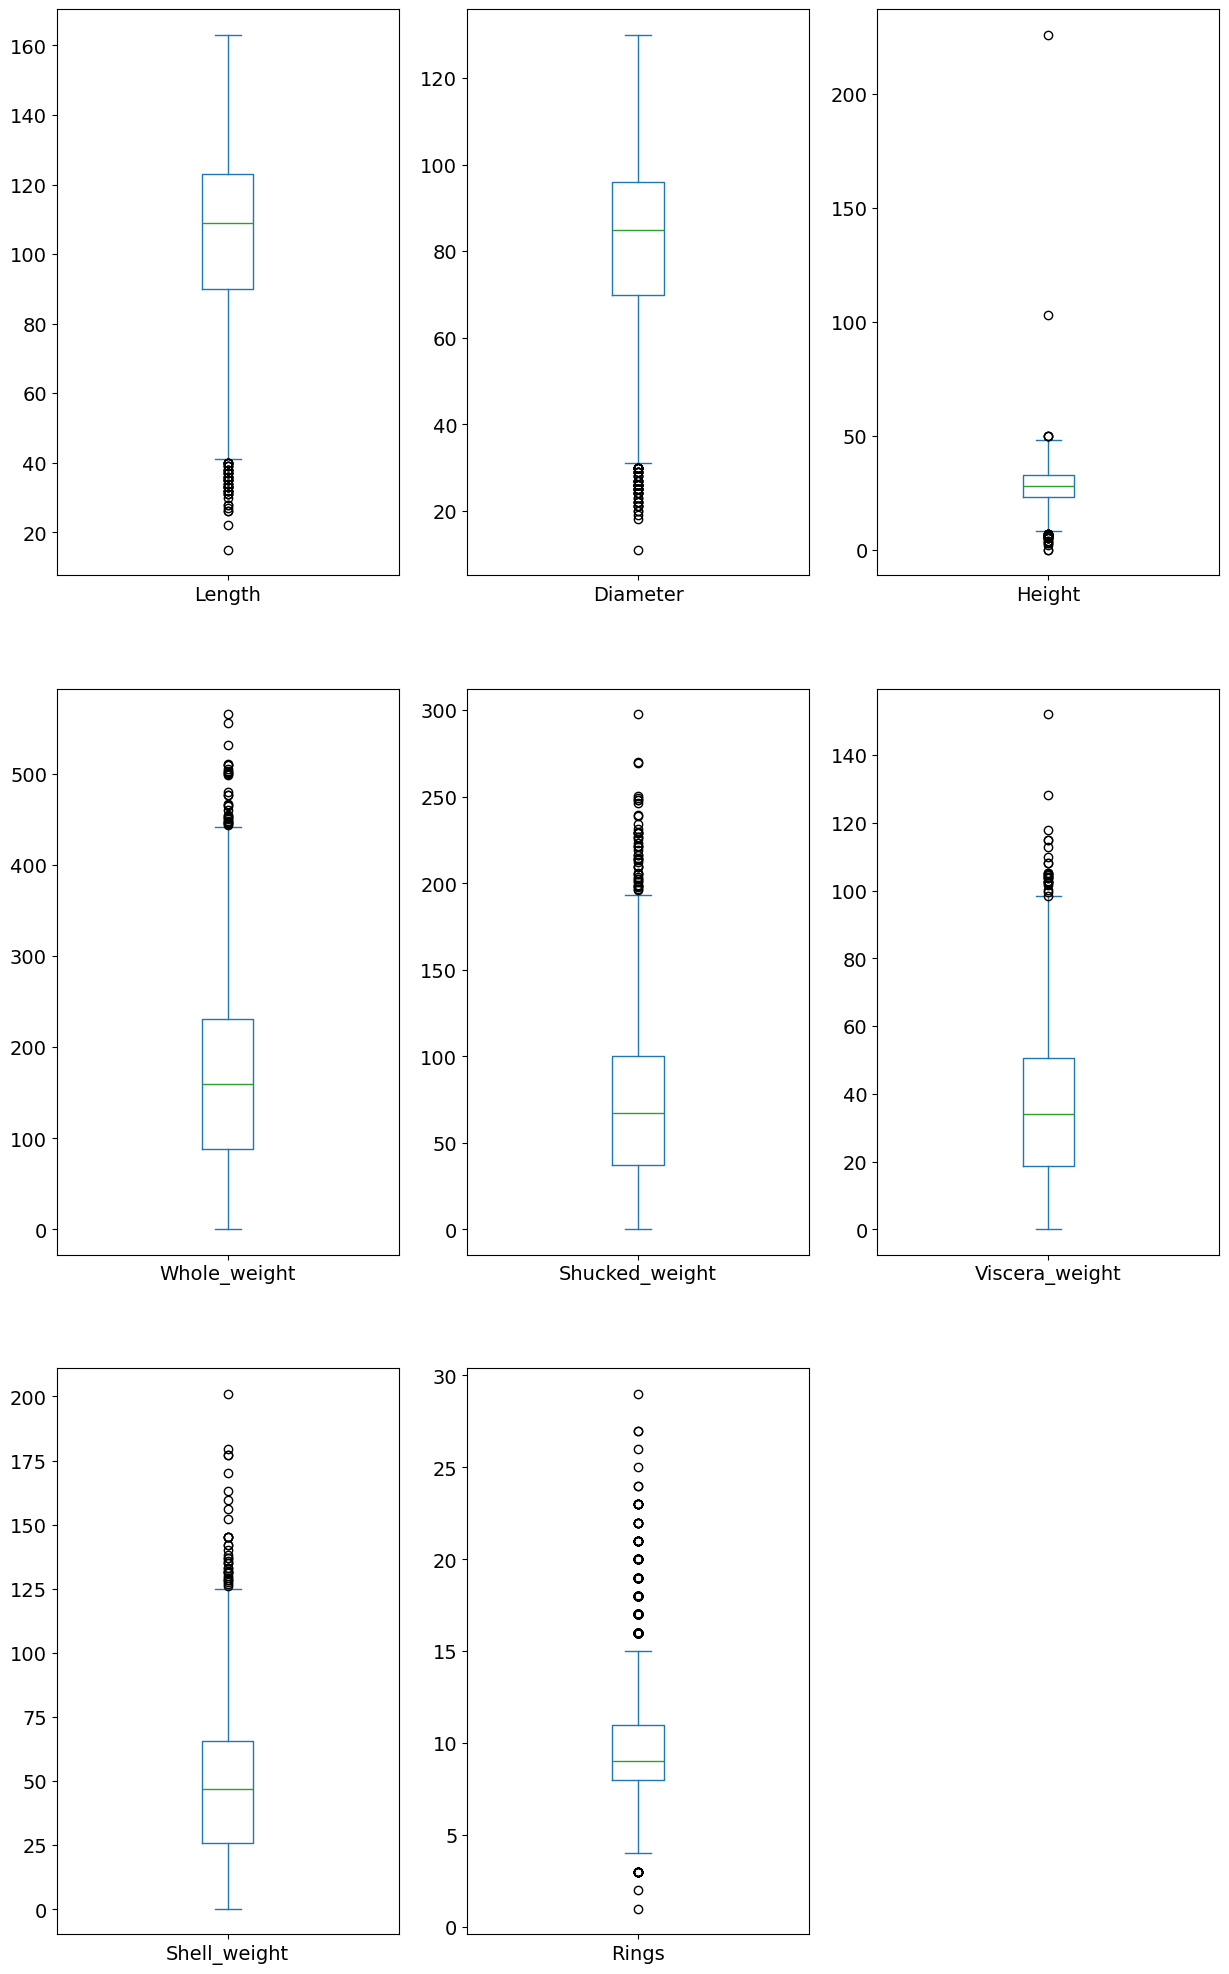

In [338]:
data_mean = df.iloc[:, :]
data_mean.plot(kind='box', subplots=True, layout=(3,3), sharex=False, 
sharey=False, fontsize=14, figsize=(15,25))

In [339]:
from sklearn.linear_model import LinearRegression

# Filter out rows where Height is 0 (these are the outliers)
train_data = df[df['Height'] != 0]
outliers_data = df[df['Height'] == 0]

# Prepare the data
X_train = train_data[['Length']]
y_train = train_data['Height']

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict heights for rows where Height == 0
X_outliers = outliers_data[['Length']]
df.loc[df['Height'] == 0, 'Height'] = model.predict(X_outliers)

In [340]:
# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile) for 'Height'
Q1 = df['Height'].quantile(0.25)
Q3 = df['Height'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Identify outliers
outliers = df[(df['Height'] < lower_bound) | (df['Height'] > upper_bound)]

# Print outliers
print("Outliers in 'Height':")
print(outliers)

# Step 4: Handling outliers by capping
# Remove infant whose height larger than upper bound, non-infant smaller than lower bound
df = df[~((df['Height'] > upper_bound) & (df['Sex_I'] == True))]
df = df[~((df['Height'] < lower_bound) & (df['Sex_I'] == False))]
df['Height'] = df['Height'].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
# Print the modified DataFrame
outliers = df[(df['Height'] < lower_bound) | (df['Height'] > upper_bound)]


Outliers in 'Height':
      Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
236     15.0      11.0     2.0           0.4             0.2             0.1   
237     26.0      20.0     6.0           2.6             0.9             0.6   
238     22.0      18.0     6.0           1.6             0.5             0.4   
239     32.0      24.0     7.0           4.2             1.5             0.9   
306     33.0      24.0     6.0           4.3             1.4             1.0   
694     33.0      22.0     4.0           3.8             1.3             0.5   
718     36.0      25.0     7.0           5.3             1.9             1.1   
719     30.0      20.0     5.0           3.0             0.9             0.8   
720     32.0      22.0     5.0           3.6             1.3             1.1   
1174   127.0      99.0     3.0         231.3           102.3            61.6   
1417   141.0     113.0   103.0         442.0           221.5            97.3   
1428   163.0     1

In [341]:
# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile) for 'Height'
Q1 = df['Length'].quantile(0.25)
Q3 = df['Length'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Identify outliers
outliers = df[(df['Length'] < lower_bound) | (df['Length'] > upper_bound)]

# Print outliers
print("Outliers in 'Length':")
print(outliers)

# Step 4: Handling outliers by capping
# Any value below lower_bound will be set to lower_bound, any above upper_bound will be set to upper_bound
df = df[~((df['Length'] > upper_bound) & (df['Sex_I'] == True))]
df = df[~((df['Length'] < lower_bound) & (df['Sex_I'] == False))]
df['Length'] = df['Length'].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

# Print the modified DataFrame
print("\nData after capping outliers in 'Length':")
print(df)


Outliers in 'Length':
      Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
148     35.0      26.0    11.0           6.3             2.1             1.3   
149     34.0      26.0    19.0           6.0             2.6             1.6   
236     15.0      11.0     8.0           0.4             0.2             0.1   
237     26.0      20.0     8.0           2.6             0.9             0.6   
238     22.0      18.0     8.0           1.6             0.5             0.4   
239     32.0      24.0     8.0           4.2             1.5             0.9   
305     40.0      29.0    12.0           7.4             2.5             1.9   
306     33.0      24.0     8.0           4.3             1.4             1.0   
321     38.0      29.0     8.0           7.6             3.3             1.3   
465     35.0      25.0    10.0           4.7             1.6             0.7   
523     40.0      28.0    11.0           7.0             2.9             1.6   
525     35.0      

In [342]:
# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile) for 'Diameter'
Q1 = df['Diameter'].quantile(0.25)
Q3 = df['Diameter'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Identify outliers
outliers = df[(df['Diameter'] < lower_bound) | (df['Diameter'] > upper_bound)]

# Print outliers
print("Outliers in 'Diameter':")
print(outliers)

# Step 4: Handling outliers by capping
# Any value below lower_bound will be set to lower_bound, any above upper_bound will be set to upper_bound
df = df[~((df['Diameter'] > upper_bound) & (df['Sex_I'] == True))]
df = df[~((df['Diameter'] < lower_bound) & (df['Sex_I'] == False))]
df['Diameter'] = df['Diameter'].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

# Print the modified DataFrame
print("\nData after capping outliers in 'Diameter':")
print(df)


Outliers in 'Diameter':
      Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
43      41.0      30.0    11.0           8.4             5.1             3.0   
44      42.0      30.0    10.0           8.4             3.5             2.5   
148     40.5      26.0    11.0           6.3             2.1             1.3   
149     40.5      26.0    19.0           6.0             2.6             1.6   
236     40.5      11.0     8.0           0.4             0.2             0.1   
237     40.5      20.0     8.0           2.6             0.9             0.6   
238     40.5      18.0     8.0           1.6             0.5             0.4   
239     40.5      24.0     8.0           4.2             1.5             0.9   
305     40.5      29.0    12.0           7.4             2.5             1.9   
306     40.5      24.0     8.0           4.3             1.4             1.0   
321     40.5      29.0     8.0           7.6             3.3             1.3   
465     40.5    

Length               Axes(0.125,0.653529;0.227941x0.226471)
Diameter          Axes(0.398529,0.653529;0.227941x0.226471)
Height            Axes(0.672059,0.653529;0.227941x0.226471)
Whole_weight         Axes(0.125,0.381765;0.227941x0.226471)
Shucked_weight    Axes(0.398529,0.381765;0.227941x0.226471)
Viscera_weight    Axes(0.672059,0.381765;0.227941x0.226471)
Shell_weight             Axes(0.125,0.11;0.227941x0.226471)
Rings                 Axes(0.398529,0.11;0.227941x0.226471)
dtype: object

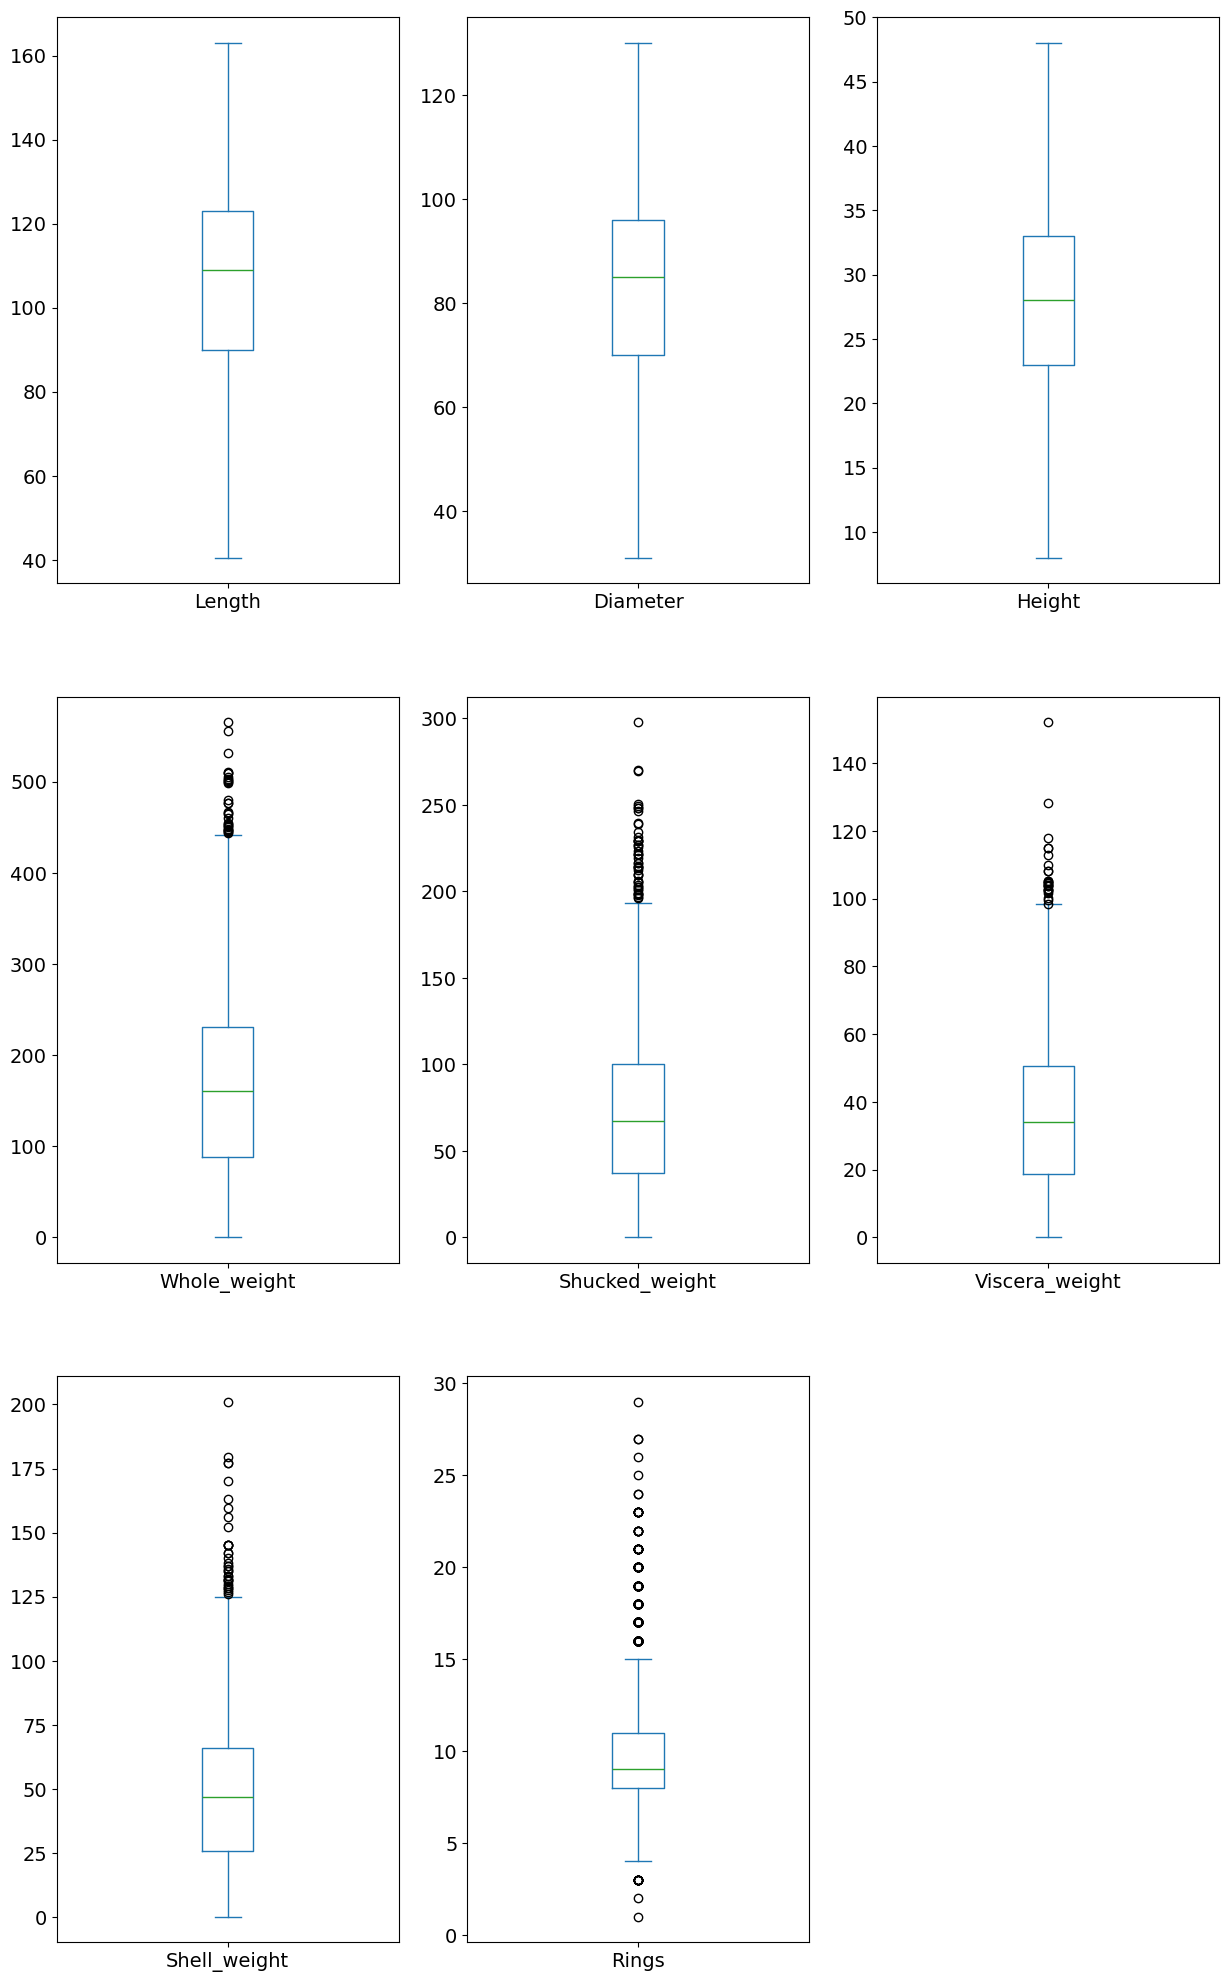

In [343]:
data_mean = df.iloc[:, :]
data_mean.plot(kind='box', subplots=True, layout=(3,3), sharex=False, 
sharey=False, fontsize=14, figsize=(15,25))

In [344]:
df['volume'] = (1/6) * np.pi * df['Length'] * df['Diameter'] * df['Height'] / 1000
df = df.drop(columns=['Length','Diameter','Height'])

In [345]:
#df['density'] = df['Whole_weight'] / (df['volume'] + 1)
df['shucked_weight_ratio'] = df['Shucked_weight'] / (df['Whole_weight'] + 1)
df['viscera_weight_ratio'] = df['Viscera_weight'] / (df['Whole_weight'] + 1)
df['shell_weight_ratio'] = df['Shell_weight'] / (df['Whole_weight'] + 1)

lower_bound = 0
upper_bound = 0.8
df = df[(df['shucked_weight_ratio'] >= lower_bound) & (df['shucked_weight_ratio'] <= upper_bound)]
df = df[(df['viscera_weight_ratio'] >= lower_bound) & (df['viscera_weight_ratio'] <= upper_bound)]
df = df[(df['shell_weight_ratio'] >= lower_bound) & (df['shell_weight_ratio'] <= upper_bound)]

#df = df.drop(columns=['Whole_weight'])
df = df.drop(columns=['Shucked_weight'])
df = df.drop(columns=['Viscera_weight'])
df = df.drop(columns=['Shell_weight'])
print("numbers:", len(df))



numbers: 4159


Whole_weight               Axes(0.125,0.653529;0.227941x0.226471)
Rings                   Axes(0.398529,0.653529;0.227941x0.226471)
volume                  Axes(0.672059,0.653529;0.227941x0.226471)
shucked_weight_ratio       Axes(0.125,0.381765;0.227941x0.226471)
viscera_weight_ratio    Axes(0.398529,0.381765;0.227941x0.226471)
shell_weight_ratio      Axes(0.672059,0.381765;0.227941x0.226471)
dtype: object

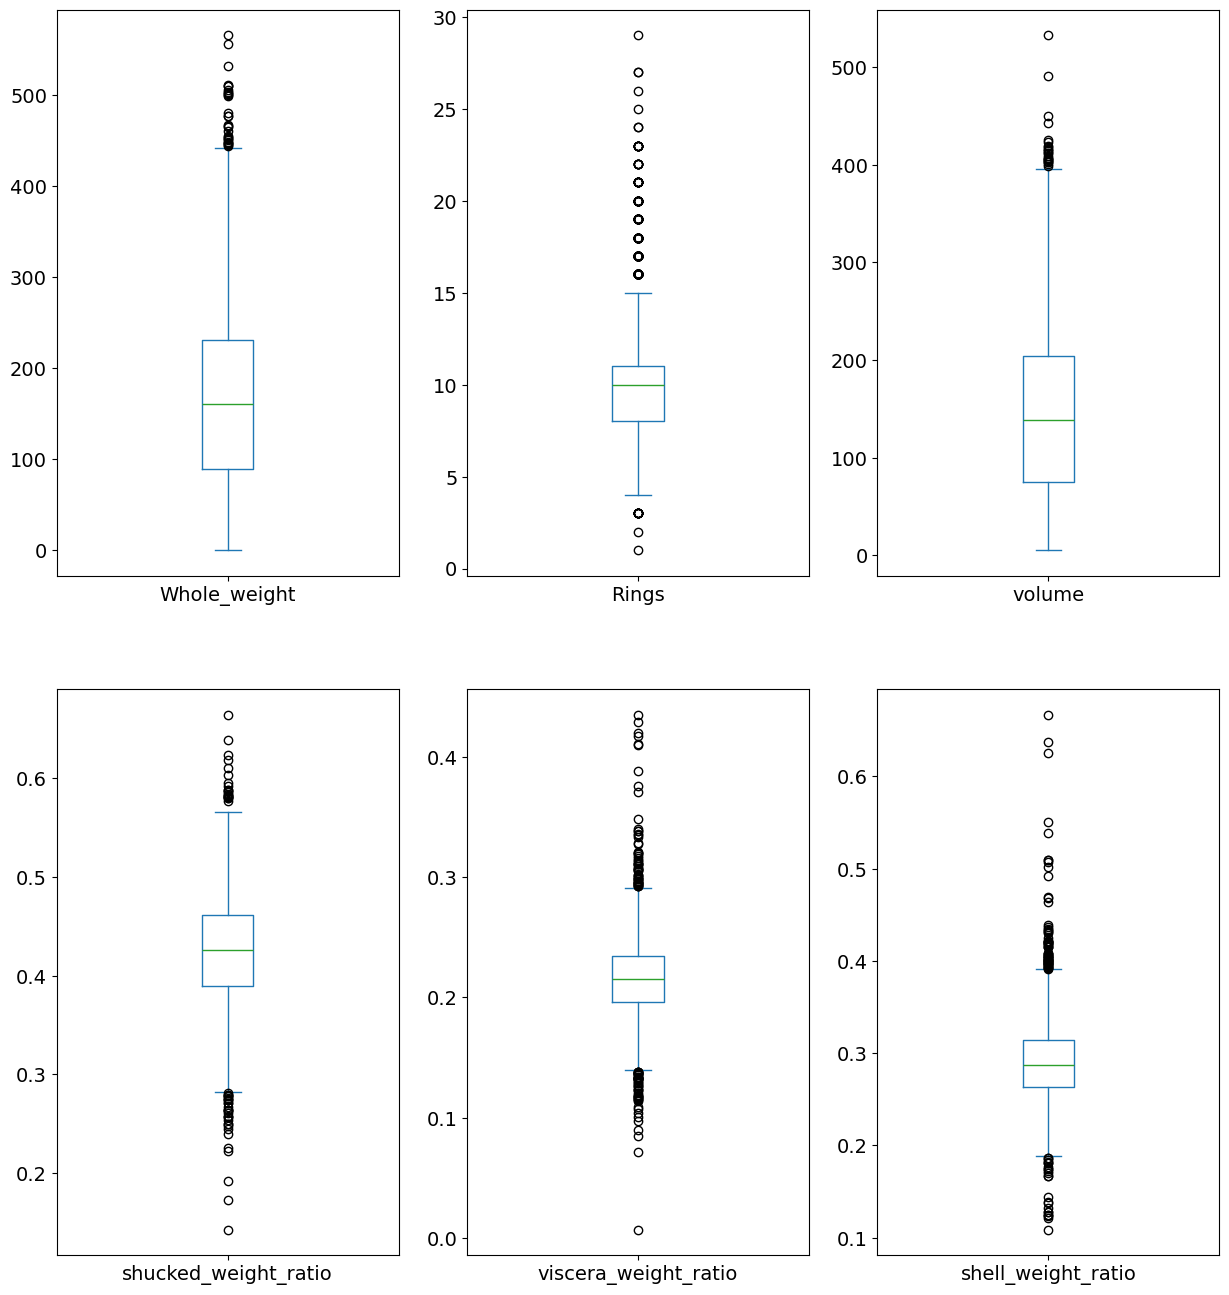

In [346]:
data_mean = df.iloc[:, :]
data_mean.plot(kind='box', subplots=True, layout=(3,3), sharex=False, 
sharey=False, fontsize=14, figsize=(15,25))

In [347]:
from sklearn.preprocessing import MinMaxScaler

exclude_columns = ['Sex_F', 'Sex_I', 'Sex_M', 'Rings']

# Separate columns to scale and those to exclude
columns_to_scale = df.columns.difference(exclude_columns)
scaler = MinMaxScaler()

# Apply scaling only to selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df.head(10)
df.describe()

,Whole_weight,Rings,volume,shucked_weight_ratio,viscera_weight_ratio,shell_weight_ratio
count,4159.000000,4159.000000,4159.000000,4159.000000,4159.000000,4159.000000
mean,0.293837,9.953595,0.266398,0.540875,0.487591,0.326341
std,0.173243,3.214926,0.165287,0.105958,0.075661,0.076283
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.157163,8.000000,0.133252,0.473281,0.442020,0.277224
50%,0.283513,10.000000,0.251909,0.543255,0.485892,0.319373
75%,0.408181,11.000000,0.378016,0.611287,0.531798,0.369123
max,1.000000,29.000000,1.000000,1.000000,1.000000,1.000000


Whole_weight               Axes(0.125,0.653529;0.168478x0.226471)
Rings                   Axes(0.327174,0.653529;0.168478x0.226471)
volume                  Axes(0.529348,0.653529;0.168478x0.226471)
shucked_weight_ratio    Axes(0.731522,0.653529;0.168478x0.226471)
viscera_weight_ratio       Axes(0.125,0.381765;0.168478x0.226471)
shell_weight_ratio      Axes(0.327174,0.381765;0.168478x0.226471)
dtype: object

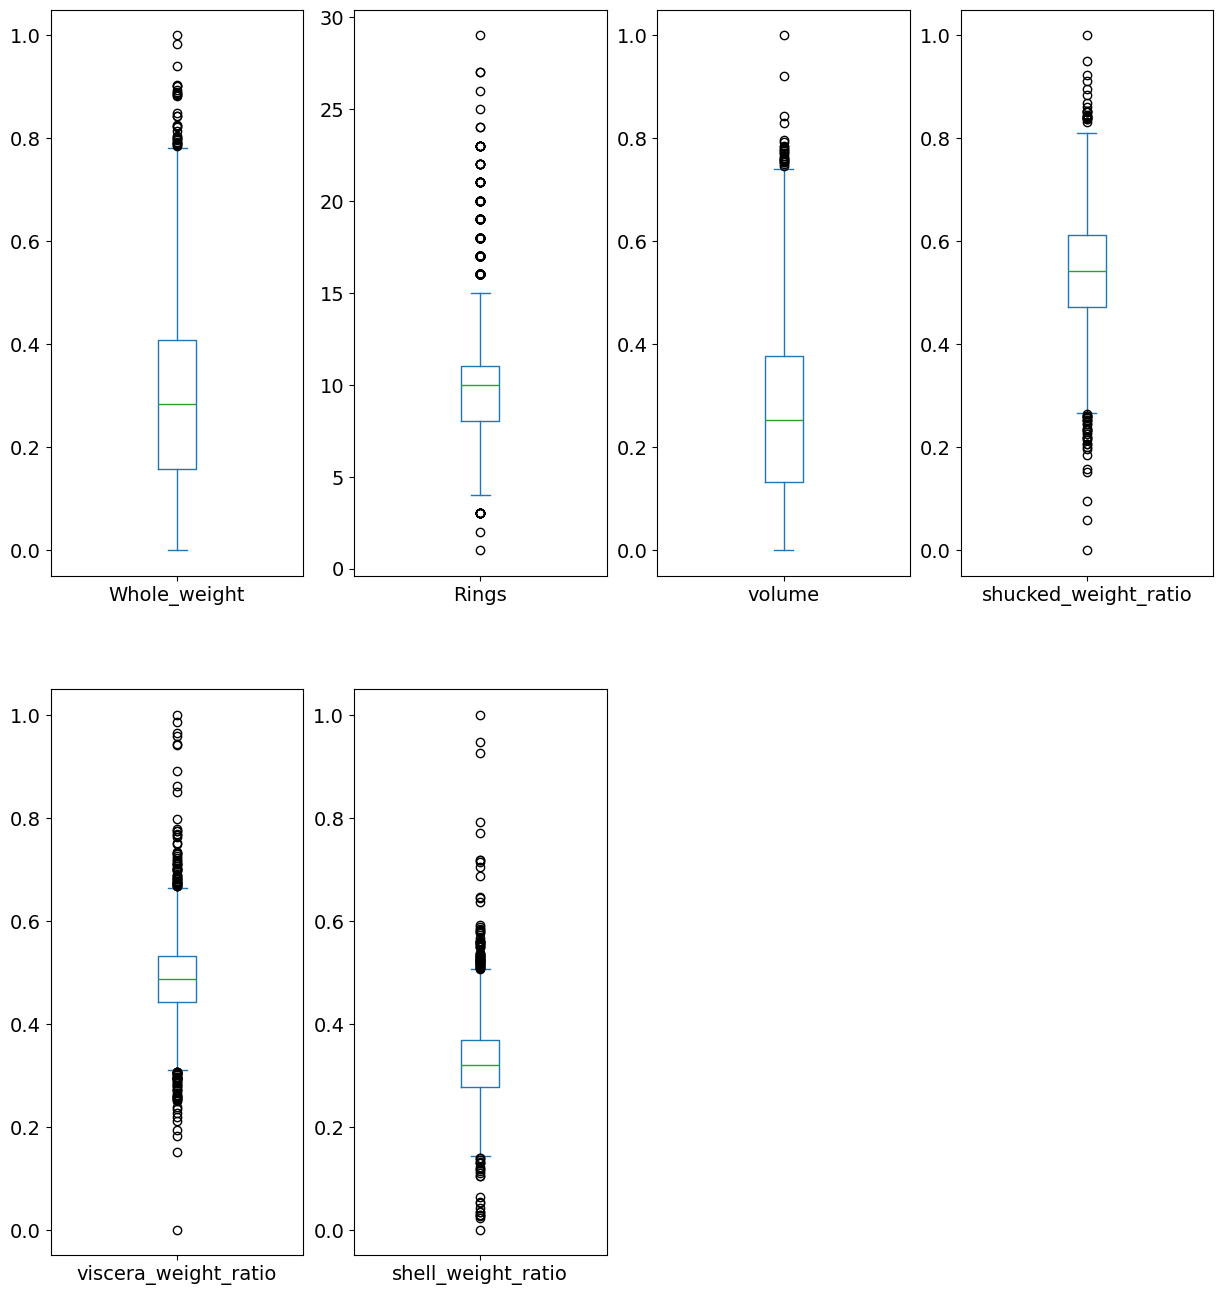

In [348]:
data_mean = df.iloc[:, :]
data_mean.plot(kind='box', subplots=True, layout=(3,4), sharex=False, 
sharey=False, fontsize=14, figsize=(15,25))

<Axes: title={'center': 'Abalone Regression'}>

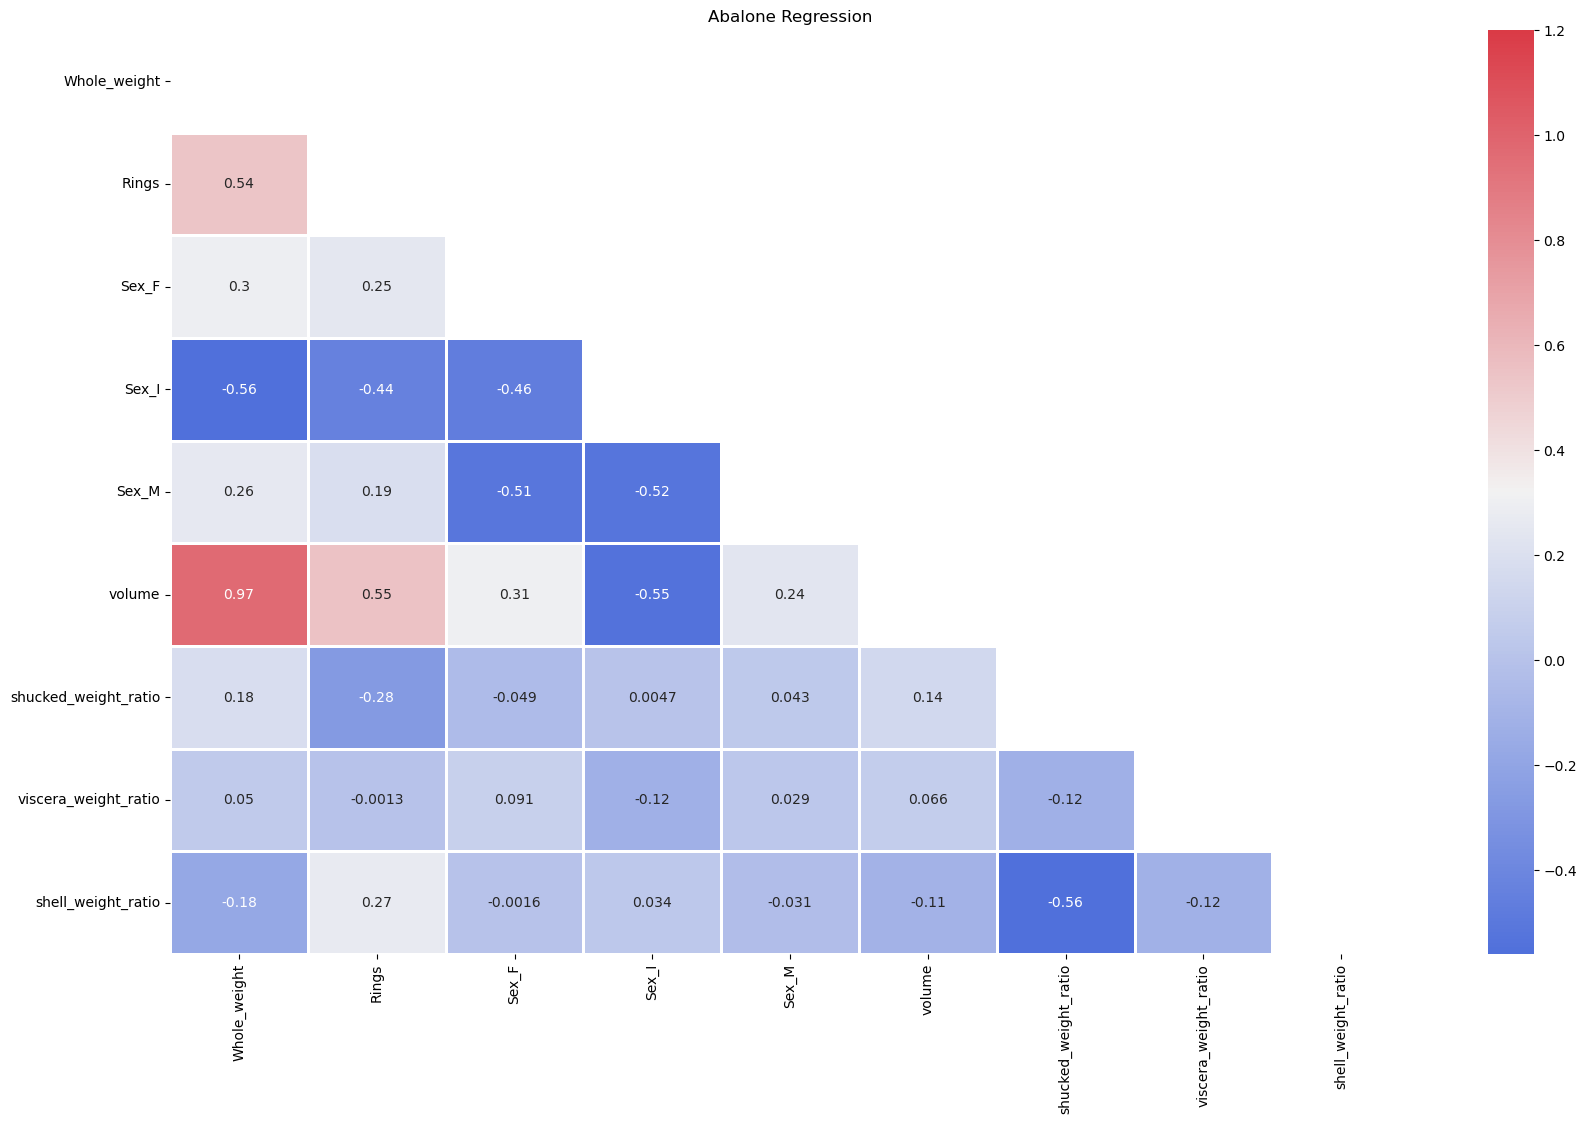

In [349]:


corrMatt = df.corr(numeric_only=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 12))
plt.title('Abalone Regression')
# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, 
ax=ax, annot=True, fmt='.2g', linewidths=1)

In [350]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

ys = y.values.ravel()

def classify(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    # train the model
    model.fit(X_train, y_train)
    print("Accuracy:", model.score(X_test, y_test) * 100, "%")
    
    y_pred = model.predict(X)
    # calculate MSE
    mse = root_mean_squared_error(y, y_pred)
    print("Mean Squared Error:", mse)

X, y = df.drop(columns=['Rings']), df['Rings'] 
model = LinearRegression()
classify(model, X, y)

# cross-validation
n_folds = 5
scores = cross_val_score(model, X, y, cv=5)
print(scores)
avg = (100 * np.mean(scores), 100 * np.std(scores)/np.sqrt(scores.shape[0]))
print("Average score and standard deviation: (%.4f +- %.5f)%%" %avg)

Accuracy: 51.114809494046966 %
Mean Squared Error: 2.3057867860930914
[0.35209115 0.16863283 0.48287137 0.50346654 0.3780492 ]
Average score and standard deviation: (37.7022 +- 5.33820)%
